In [1]:
from torch.utils.data import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
trainimages = np.load('datasets/training/basalt_images_train.npy')
trainlabels = np.load('datasets/training/basalt_gt_train.npy')
trainlabels = np.squeeze(trainlabels, axis=1)
print(trainlabels.shape)
valimages = np.load('datasets/validation/basalt_images_val.npy')
vallabels = np.load('datasets/validation/basalt_gt_val.npy')
vallabels = np.squeeze(vallabels, axis=1)
print(vallabels.shape)

(120, 448, 448)
(30, 448, 448)


In [3]:
trainlabels = np.where(trainlabels == 1, 2,1)
print(np.unique(trainlabels))
vallabels = np.where(vallabels == 1, 2,1)
print(np.unique(vallabels))

[1 2]
[1 2]


In [4]:
class SegmentationDataset(Dataset):
  def __init__(self, dataset, lables, transform=None):
    self.dataset = dataset
    self.lables = lables
    self.transform = transform

  def __len__(self):
    return self.dataset.shape[0]

  def __getitem__(self, idx):
    image = self.dataset[idx]
    label = self.lables[idx]
    #original_image = np.array(item["image"])
    #original_segmentation_map = np.array(item["label"])
    if self.transform:
      augmented = self.transform(image=image, mask=label)      
      image = augmented['image']
      label = augmented['mask']
      return torch.tensor(image), torch.LongTensor(label)
    else:
      return torch.tensor(image), torch.LongTensor(label)
     

In [5]:
print(trainimages.shape)
print(trainlabels.shape)
dataset = SegmentationDataset(trainimages, trainlabels)

print(len(dataset))
sample, label = dataset[0]  # Get the first sample and its label
print(sample.shape)  # This will print the shape of the first sample
print(label.shape)  # This will print the label for the first sample


(120, 3, 448, 448)
(120, 448, 448)
120
torch.Size([3, 448, 448])
torch.Size([448, 448])


In [6]:
import albumentations as A
train_transform = A.Compose([
    # hadded an issue with an image being too small to crop, PadIfNeeded didn't help...
    # if anyone knows why this is happening I'm happy to read why
    # A.PadIfNeeded(min_height=448, min_width=448),
    # A.RandomResizedCrop(height=448, width=448),
    #A.Resize(width=448, height=448),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.RandomRotate90(p=0.5),
    #A.GaussNoise(p=0.2),
], is_check_shapes=False)




In [7]:
print(train_transform)

Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  VerticalFlip(always_apply=False, p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=False)


In [8]:
print(trainimages.shape)
print(trainlabels.shape)
train_dataset = SegmentationDataset(trainimages, trainlabels, transform=train_transform)
val_dataset = SegmentationDataset(valimages, vallabels, transform=train_transform)
print(len(train_dataset))
sample, label = train_dataset[0]  # Get the first sample and its label
print(sample.shape)  # This will print the shape of the first sample
print(label.shape)

(120, 3, 448, 448)
(120, 448, 448)
120
torch.Size([3, 448, 448])
torch.Size([448, 448])


In [9]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [10]:
for idx, batch in enumerate(train_dataloader):
    print(idx, batch)
    print(batch[0].shape)
    print(batch[1].shape)
    print(type(batch[1]))
    break

0 [tensor([[[[0.1028, 0.1043, 0.1135,  ..., 0.1169, 0.1071, 0.1147],
          [0.0914, 0.0907, 0.0906,  ..., 0.1094, 0.1094, 0.1092],
          [0.0851, 0.0898, 0.0904,  ..., 0.1071, 0.1038, 0.1086],
          ...,
          [0.1832, 0.1751, 0.1752,  ..., 0.1855, 0.1919, 0.1970],
          [0.1855, 0.1855, 0.1761,  ..., 0.2178, 0.1874, 0.1790],
          [0.2082, 0.1961, 0.1787,  ..., 0.2097, 0.1988, 0.1955]],

         [[0.4376, 0.4218, 0.3779,  ..., 0.4890, 0.4806, 0.4368],
          [0.4671, 0.4659, 0.4447,  ..., 0.4817, 0.4817, 0.4648],
          [0.4531, 0.4579, 0.4690,  ..., 0.4773, 0.4812, 0.4658],
          ...,
          [0.3057, 0.2633, 0.2496,  ..., 0.3983, 0.2770, 0.1639],
          [0.3607, 0.3607, 0.2850,  ..., 0.4577, 0.4235, 0.3945],
          [0.4365, 0.4076, 0.3041,  ..., 0.4522, 0.4422, 0.4343]],

         [[0.2503, 0.2614, 0.2655,  ..., 0.2273, 0.2237, 0.2650],
          [0.2719, 0.2807, 0.2846,  ..., 0.2391, 0.2391, 0.2355],
          [0.2963, 0.2835, 0.2762,  ...

In [11]:
import torch
from transformers import Dinov2Model, Dinov2PreTrainedModel
from transformers.modeling_outputs import SemanticSegmenterOutput

class LinearClassifier(torch.nn.Module):
    def __init__(self, in_channels, tokenW=32, tokenH=32, num_labels=1):
        super(LinearClassifier, self).__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.classifier = torch.nn.Conv2d(in_channels, num_labels, (1,1))

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.classifier(embeddings)

/root/.conda/envs/hypermoon/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
class Dinov2ForSemanticSegmentation(Dinov2PreTrainedModel):
  def __init__(self, config):
    super().__init__(config)

    self.dinov2 = Dinov2Model(config)
    self.classifier = LinearClassifier(config.hidden_size, 32, 32, config.num_labels)

  def forward(self, pixel_values, output_hidden_states=False, output_attentions=False, labels=None):
    # use frozen features
    outputs = self.dinov2(pixel_values,
                            output_hidden_states=output_hidden_states,
                            output_attentions=output_attentions)
    # get the patch embeddings - so we exclude the CLS token
    patch_embeddings = outputs.last_hidden_state[:,1:,:]

    # convert to logits and upsample to the size of the pixel values
    logits = self.classifier(patch_embeddings)
    logits = torch.nn.functional.interpolate(logits, size=pixel_values.shape[2:], mode="bilinear", align_corners=False)

    loss = None
    if labels is not None:
      # important: we're going to use 0 here as ignore index instead of the default -100
      # as we don't want the model to learn to predict background
      #loss_fct = torch.nn.CrossEntropyLoss(ignore_index=0)
      loss_fct = torch.nn.CrossEntropyLoss()
      #loss_fct = torch.nn.BCEWithLogitsLoss()

      loss = loss_fct(logits.squeeze(), labels.squeeze())

    return SemanticSegmenterOutput(
        loss=loss,
        logits=logits,
        hidden_states=outputs.hidden_states,
        attentions=outputs.attentions,
    )

In [20]:
id2label = {
    0: "background",
    1: "no basalt",
    2: "basalt"
}
    

In [21]:
model = Dinov2ForSemanticSegmentation.from_pretrained("facebook/dinov2-base", id2label=id2label, num_labels=len(id2label))


Some weights of Dinov2ForSemanticSegmentation were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.classifier.bias', 'classifier.classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
for name, param in model.named_parameters():
    print(name)
    if name.startswith("dinov2"):
        param.requires_grad = False

dinov2.embeddings.cls_token
dinov2.embeddings.mask_token
dinov2.embeddings.position_embeddings
dinov2.embeddings.patch_embeddings.projection.weight
dinov2.embeddings.patch_embeddings.projection.bias
dinov2.encoder.layer.0.norm1.weight
dinov2.encoder.layer.0.norm1.bias
dinov2.encoder.layer.0.attention.attention.query.weight
dinov2.encoder.layer.0.attention.attention.query.bias
dinov2.encoder.layer.0.attention.attention.key.weight
dinov2.encoder.layer.0.attention.attention.key.bias
dinov2.encoder.layer.0.attention.attention.value.weight
dinov2.encoder.layer.0.attention.attention.value.bias
dinov2.encoder.layer.0.attention.output.dense.weight
dinov2.encoder.layer.0.attention.output.dense.bias
dinov2.encoder.layer.0.layer_scale1.lambda1
dinov2.encoder.layer.0.norm2.weight
dinov2.encoder.layer.0.norm2.bias
dinov2.encoder.layer.0.mlp.fc1.weight
dinov2.encoder.layer.0.mlp.fc1.bias
dinov2.encoder.layer.0.mlp.fc2.weight
dinov2.encoder.layer.0.mlp.fc2.bias
dinov2.encoder.layer.0.layer_scale2.lam

In [16]:
import evaluate

metric = evaluate.load("mean_iou")

2023-11-14 12:08:58.107885: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 12:08:58.119853: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 12:08:58.202998: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 12:08:58.203065: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 12:08:58.203288: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [24]:
from torch.optim import AdamW
from tqdm.auto import tqdm

# training hyperparameters
# NOTE: I've just put some random ones here, not optimized at all
# feel free to experiment, see also DINOv2 paper
learning_rate = 0.1
epochs = 50

optimizer = AdamW(model.parameters(), lr=learning_rate)

# put model on GPU (set runtime to GPU in Google Colab)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# put model in training mode
model.train()

for epoch in range(epochs):
  print("Epoch:", epoch)
  for idx, batch in enumerate(tqdm(train_dataloader)):
      pixel_values = batch[0].to(device)
      labels = batch[1].to(device)

      # forward pass
      outputs = model(pixel_values, labels=labels)
      loss = outputs.loss

      loss.backward()
      optimizer.step()

      # zero the parameter gradients
      optimizer.zero_grad()
      # evaluate
      with torch.no_grad():
        predicted = outputs.logits.argmax(dim=1)

        # note that the metric expects predictions + labels as numpy arrays
        metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

      # let's print loss and metrics every 100 batches
      if idx % 100 == 0:
        metrics = metric.compute(num_labels=len(id2label),
                                ignore_index=0,
                                reduce_labels=False,
        )

        print("Loss:", loss.item())
        print("Mean_iou:", metrics["mean_iou"])
        print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/15 [00:00<?, ?it/s]/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
  7%|▋         | 1/15 [00:07<01:49,  7.82s/it]

Loss: 0.01805015280842781
Mean_iou: 0.49936684675497806
Mean accuracy: 0.5


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


Epoch: 1


  7%|▋         | 1/15 [00:10<02:31, 10.81s/it]

Loss: 0.4205360412597656
Mean_iou: 0.496901716769608
Mean accuracy: 0.5020899606235419


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


Epoch: 2


  7%|▋         | 1/15 [00:11<02:47, 11.95s/it]

Loss: 0.4137019217014313
Mean_iou: 0.4993535463501807
Mean accuracy: 0.5


100%|██████████| 15/15 [00:39<00:00,  2.63s/it]


Epoch: 3


  7%|▋         | 1/15 [00:10<02:29, 10.67s/it]

Loss: 0.3264996409416199
Mean_iou: 0.499340363586841
Mean accuracy: 0.4999981706906898


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Epoch: 4


  7%|▋         | 1/15 [00:10<02:28, 10.59s/it]

Loss: 0.6600959300994873
Mean_iou: 0.49766264312362307
Mean accuracy: 0.4990422479361591


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Epoch: 5


  7%|▋         | 1/15 [00:10<02:30, 10.77s/it]

Loss: 0.23594574630260468
Mean_iou: 0.49938647211814413
Mean accuracy: 0.5


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch: 6


  7%|▋         | 1/15 [00:10<02:30, 10.78s/it]

Loss: 0.20650678873062134
Mean_iou: 0.4995952737652622
Mean accuracy: 0.5003718697960169


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch: 7


  7%|▋         | 1/15 [00:10<02:32, 10.88s/it]

Loss: 0.30263304710388184
Mean_iou: 0.4989377332718012
Mean accuracy: 0.5006046691415085


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Epoch: 8


  7%|▋         | 1/15 [00:11<02:34, 11.06s/it]

Loss: 0.11480215936899185
Mean_iou: 0.49961139722162096
Mean accuracy: 0.5009201473284433


100%|██████████| 15/15 [00:36<00:00,  2.47s/it]


Epoch: 9


  7%|▋         | 1/15 [00:11<02:41, 11.50s/it]

Loss: 0.06681538373231888
Mean_iou: 0.5016323968692739
Mean accuracy: 0.5041245480729583


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


Epoch: 10


  7%|▋         | 1/15 [00:10<02:27, 10.54s/it]

Loss: 0.08836836367845535
Mean_iou: 0.5000994437945925
Mean accuracy: 0.5022635725916623


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch: 11


  7%|▋         | 1/15 [00:10<02:27, 10.57s/it]

Loss: 0.04507913812994957
Mean_iou: 0.5050324912094781
Mean accuracy: 0.5144748113056085


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Epoch: 12


  7%|▋         | 1/15 [00:10<02:29, 10.67s/it]

Loss: 0.1397407352924347
Mean_iou: 0.500328530953788
Mean accuracy: 0.5020615798445837


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Epoch: 13


  7%|▋         | 1/15 [00:10<02:25, 10.41s/it]

Loss: 0.08263731002807617
Mean_iou: 0.5072248472299447
Mean accuracy: 0.5119214638731084


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Epoch: 14


  7%|▋         | 1/15 [00:10<02:29, 10.68s/it]

Loss: 0.03961726650595665
Mean_iou: 0.5041417559274027
Mean accuracy: 0.5097501444730839


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Epoch: 15


  7%|▋         | 1/15 [00:10<02:31, 10.81s/it]

Loss: 0.034119024872779846
Mean_iou: 0.5010590383083238
Mean accuracy: 0.5039337298385145


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


Epoch: 16


  7%|▋         | 1/15 [00:11<02:38, 11.31s/it]

Loss: 0.05737821385264397
Mean_iou: 0.4999528634570641
Mean accuracy: 0.5013837945682769


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Epoch: 17


  7%|▋         | 1/15 [00:10<02:31, 10.84s/it]

Loss: 0.0306871198117733
Mean_iou: 0.5013852929740281
Mean accuracy: 0.5052934685361238


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Epoch: 18


  7%|▋         | 1/15 [00:10<02:27, 10.54s/it]

Loss: 0.04018388316035271
Mean_iou: 0.4999614204588213
Mean accuracy: 0.501205554515126


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch: 19


  7%|▋         | 1/15 [00:10<02:27, 10.55s/it]

Loss: 0.19645167887210846
Mean_iou: 0.5027419572771852
Mean accuracy: 0.5089893638260322


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Epoch: 20


  7%|▋         | 1/15 [00:10<02:30, 10.73s/it]

Loss: 0.03990933299064636
Mean_iou: 0.49908656556604614
Mean accuracy: 0.49983000047337517


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Epoch: 21


  7%|▋         | 1/15 [00:10<02:27, 10.52s/it]

Loss: 0.05876215547323227
Mean_iou: 0.4998385750741516
Mean accuracy: 0.5015316833691409


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


Epoch: 22


  7%|▋         | 1/15 [00:10<02:29, 10.68s/it]

Loss: 0.03086179681122303
Mean_iou: 0.5022628483946353
Mean accuracy: 0.5056181733546996


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


Epoch: 23


  7%|▋         | 1/15 [00:10<02:31, 10.80s/it]

Loss: 0.2691270709037781
Mean_iou: 0.4986142456256894
Mean accuracy: 0.5001139255972459


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Epoch: 24


  7%|▋         | 1/15 [00:10<02:31, 10.79s/it]

Loss: 0.35843902826309204
Mean_iou: 0.4995578207742825
Mean accuracy: 0.500805852049981


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch: 25


  7%|▋         | 1/15 [00:10<02:30, 10.75s/it]

Loss: 0.1743851751089096
Mean_iou: 0.5031906543564394
Mean accuracy: 0.505799626186714


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Epoch: 26


  7%|▋         | 1/15 [00:10<02:31, 10.86s/it]

Loss: 0.06948891282081604
Mean_iou: 0.5042864343797001
Mean accuracy: 0.5095031288931526


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Epoch: 27


  7%|▋         | 1/15 [00:10<02:30, 10.75s/it]

Loss: 0.09198204427957535
Mean_iou: 0.49940181348832385
Mean accuracy: 0.501707886182199


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Epoch: 28


  7%|▋         | 1/15 [00:10<02:32, 10.87s/it]

Loss: 0.07536698132753372
Mean_iou: 0.4992144318664966
Mean accuracy: 0.49986344857353543


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Epoch: 29


  7%|▋         | 1/15 [00:10<02:31, 10.84s/it]

Loss: 0.2067498117685318
Mean_iou: 0.4995983083194861
Mean accuracy: 0.5014190973025092


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


Epoch: 30


  7%|▋         | 1/15 [00:10<02:26, 10.46s/it]

Loss: 0.07892117649316788
Mean_iou: 0.5008169465828886
Mean accuracy: 0.503930880947281


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


Epoch: 31


  7%|▋         | 1/15 [00:10<02:31, 10.83s/it]

Loss: 0.0315338559448719
Mean_iou: 0.49945577796746166
Mean accuracy: 0.5004600734191275


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch: 32


  7%|▋         | 1/15 [00:10<02:30, 10.75s/it]

Loss: 0.09053580462932587
Mean_iou: 0.5028775012098556
Mean accuracy: 0.5085733092816958


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Epoch: 33


  7%|▋         | 1/15 [00:10<02:30, 10.74s/it]

Loss: 0.05996442213654518
Mean_iou: 0.5010940669620367
Mean accuracy: 0.5041757424766388


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch: 34


  7%|▋         | 1/15 [00:10<02:31, 10.80s/it]

Loss: 0.051013797521591187
Mean_iou: 0.5045171406621739
Mean accuracy: 0.5089078513869847


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


Epoch: 35


  7%|▋         | 1/15 [00:11<02:34, 11.05s/it]

Loss: 0.032481711357831955
Mean_iou: 0.502188529574453
Mean accuracy: 0.5054656902264977


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Epoch: 36


  7%|▋         | 1/15 [00:10<02:32, 10.88s/it]

Loss: 0.07941678166389465
Mean_iou: 0.503307823095464
Mean accuracy: 0.5082716265009898


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


Epoch: 37


  7%|▋         | 1/15 [00:10<02:27, 10.56s/it]

Loss: 0.12268497794866562
Mean_iou: 0.49951328149378915
Mean accuracy: 0.5011686514768199


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch: 38


  7%|▋         | 1/15 [00:10<02:28, 10.62s/it]

Loss: 0.09448021650314331
Mean_iou: 0.5021524494233212
Mean accuracy: 0.5052469968364443


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Epoch: 39


  7%|▋         | 1/15 [00:10<02:30, 10.73s/it]

Loss: 0.040096402168273926
Mean_iou: 0.5042484643655675
Mean accuracy: 0.510285411539958


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Epoch: 40


  7%|▋         | 1/15 [00:10<02:32, 10.88s/it]

Loss: 0.04057588428258896
Mean_iou: 0.5008037715197201
Mean accuracy: 0.5042702679331631


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Epoch: 41


  7%|▋         | 1/15 [00:10<02:31, 10.79s/it]

Loss: 0.03340189531445503
Mean_iou: 0.4989239958678784
Mean accuracy: 0.49956856420120144


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Epoch: 42


  7%|▋         | 1/15 [00:11<02:36, 11.17s/it]

Loss: 0.03272717446088791
Mean_iou: 0.5035242164653613
Mean accuracy: 0.5074780294481035


100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


Epoch: 43


  7%|▋         | 1/15 [00:10<02:29, 10.67s/it]

Loss: 0.07521207630634308
Mean_iou: 0.5021199464797127
Mean accuracy: 0.5063422759211614


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Epoch: 44


  7%|▋         | 1/15 [00:10<02:27, 10.54s/it]

Loss: 0.03196233510971069
Mean_iou: 0.5036806812875221
Mean accuracy: 0.508772398100711


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch: 45


  7%|▋         | 1/15 [00:10<02:28, 10.58s/it]

Loss: 0.09783390909433365
Mean_iou: 0.5021201730858237
Mean accuracy: 0.5057673720312851


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch: 46


  7%|▋         | 1/15 [00:10<02:28, 10.59s/it]

Loss: 0.10449480265378952
Mean_iou: 0.5001216010074288
Mean accuracy: 0.5041833527197375


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch: 47


  7%|▋         | 1/15 [00:10<02:26, 10.50s/it]

Loss: 0.26084935665130615
Mean_iou: 0.5004372340670702
Mean accuracy: 0.5015440945735425


100%|██████████| 15/15 [00:35<00:00,  2.40s/it]


Epoch: 48


  7%|▋         | 1/15 [00:10<02:33, 10.94s/it]

Loss: 0.08217751234769821
Mean_iou: 0.501028412395591
Mean accuracy: 0.5036092834869196


100%|██████████| 15/15 [00:36<00:00,  2.47s/it]


Epoch: 49


  7%|▋         | 1/15 [00:11<02:34, 11.06s/it]

Loss: 0.07361907511949539
Mean_iou: 0.5009198106560085
Mean accuracy: 0.5041298737260891


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


In [81]:
#compute the mean Iou on the val set
model.eval()
with torch.no_grad():
  for idx, batch in enumerate(tqdm(val_dataloader)):
      pixel_values = batch[0].to(device)
      labels = batch[1].to(device)

      # forward pass
      outputs = model(pixel_values, labels=labels)
      loss = outputs.loss

      predicted = outputs.logits.argmax(dim=1)

      # note that the metric expects predictions + labels as numpy arrays
      metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

  metrics = metric.compute(num_labels=len(id2label),
                          ignore_index=0,
                          reduce_labels=False,
  )

  print("Mean_iou:", metrics["mean_iou"])
  print("Mean accuracy:", metrics["mean_accuracy"])

100%|██████████| 4/4 [00:14<00:00,  3.56s/it]


Mean_iou: 0.0
Mean accuracy: 0.0


0
[0]
[0 1]


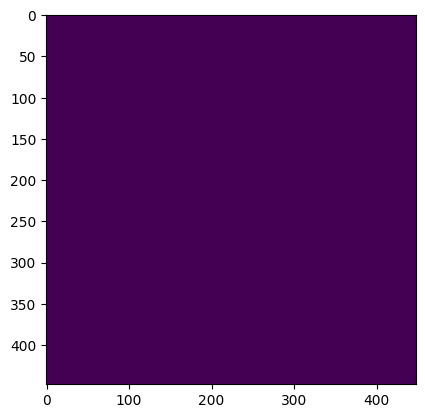

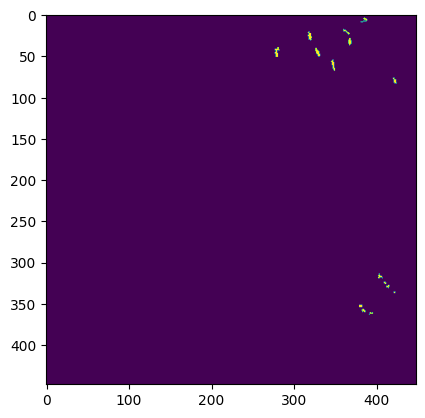

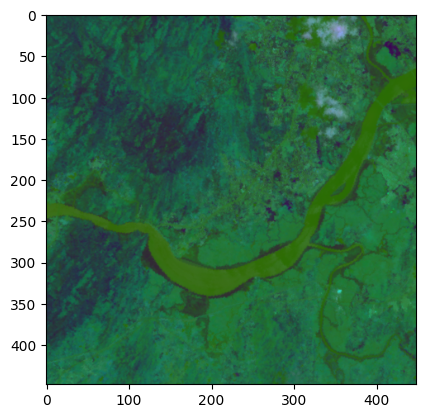

1
[0]
[0 1]


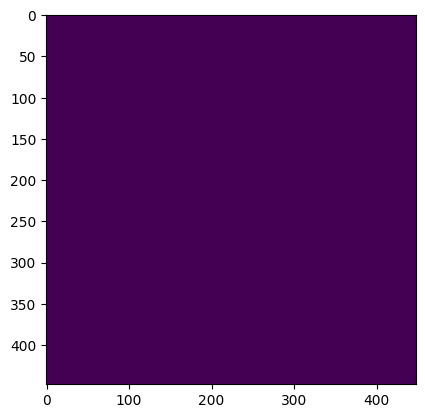

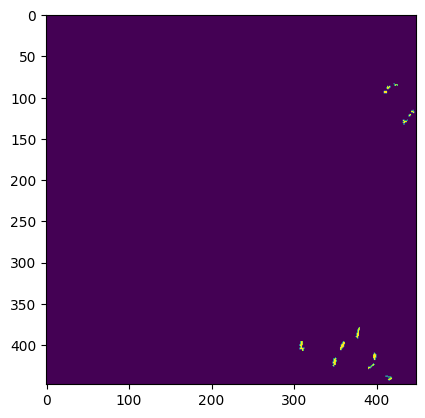

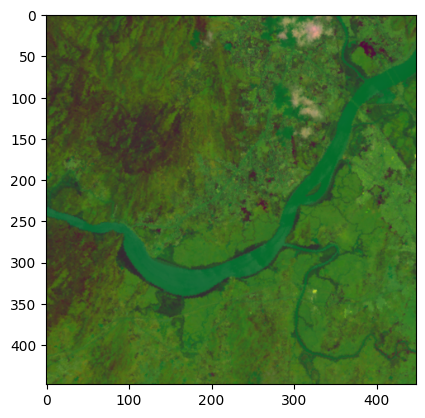

2
[0]
[0 1]


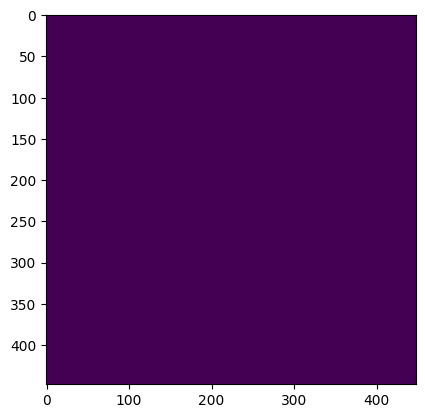

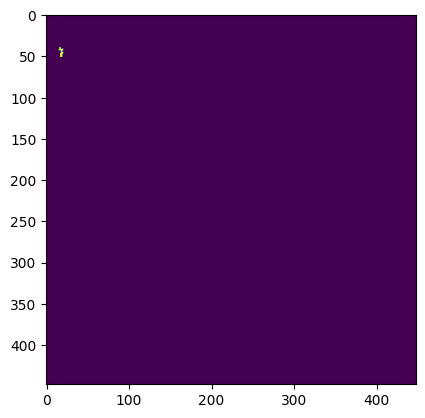

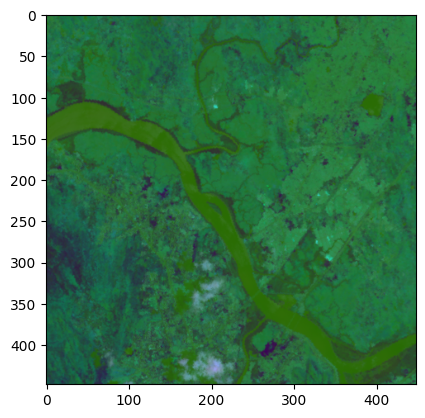

3
[0]
[0 1]


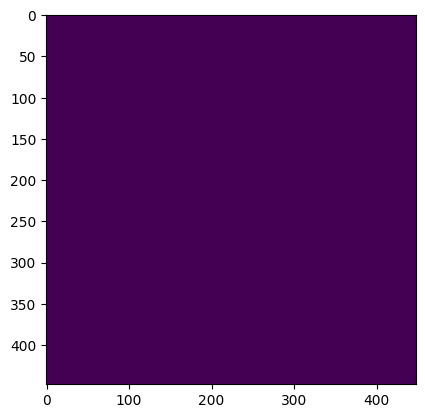

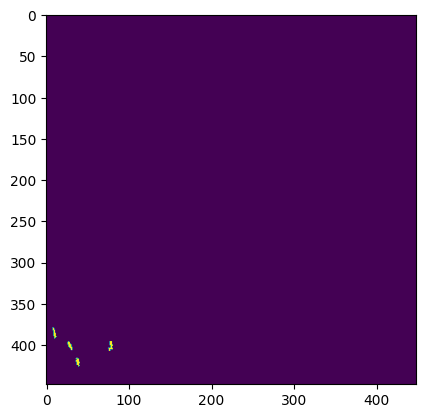

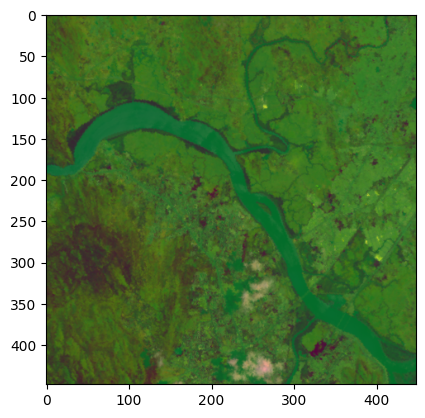

In [82]:
with torch.no_grad():
    for indx, batch in enumerate(val_dataloader):
        print(indx)
        pixel_values = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(pixel_values)
        predicted = outputs.logits.argmax(dim=1)
        print(np.unique(predicted[0].cpu().numpy()))
        print(np.unique(labels[0].cpu().numpy()))
        plt.imshow(predicted[0].cpu().numpy())
        plt.show()
        plt.imshow(labels[0].cpu().numpy())
        plt.show()
        plt.imshow(pixel_values[0].cpu().numpy().transpose(1,2,0))
        plt.show()

In [35]:
moon_test = np.load('datasets/moon_test/moon_dataset.npy')
moon_test = moon_test.astype(np.float32)

In [87]:
#torch.save(model.state_dict(), 'models/models_10Epochs.pth')

In [45]:
moon_values = torch.tensor(moon_test[6]).unsqueeze(0)
print(moon_values.size())

torch.Size([1, 3, 448, 448])


In [46]:
# forward pass
with torch.no_grad():
  outputs = model(moon_values.to(device))

torch.Size([1, 2, 448, 448])
torch.Size([1, 448, 448])


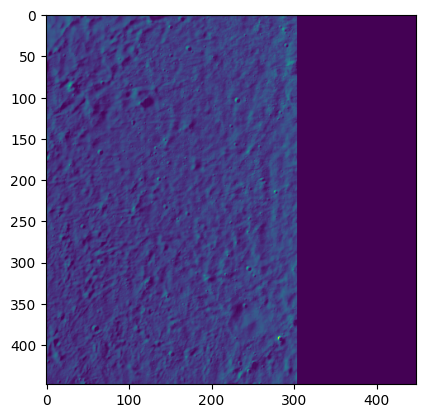

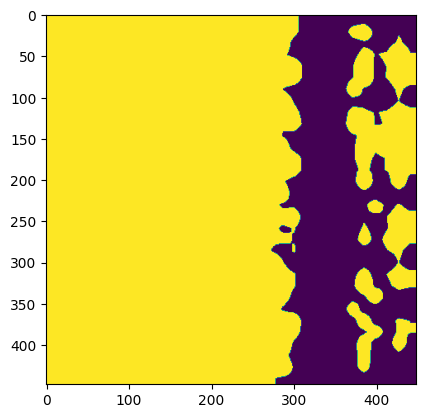

In [47]:
print(outputs.logits.size())
print(outputs.logits.argmax(dim=1).size())
plt.imshow(moon_test[6][0])
plt.show()
plt.imshow(outputs.logits.argmax(dim=1).squeeze().cpu().numpy())
plt.show()

In [92]:

upsampled_logits = torch.nn.functional.interpolate(outputs.logits,
                                                   size=m,
                                                   mode="bilinear", align_corners=False)
predicted_map = upsampled_logits.argmax(dim=1)

ValueError: either size or scale_factor should be defined